In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class SoftmaxRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-4, early_stopping=True, patience=10):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.early_stopping = early_stopping
        self.patience = patience
        self.weights = None
        self.bias = None

    def _softmax(self, logits):
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))  # Stability trick
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    def _compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        log_likelihood = -np.log(y_pred[range(m), y_true])
        return np.mean(log_likelihood)

    def _one_hot_encode(self, y, num_classes):
        m = y.shape[0]
        one_hot = np.zeros((m, num_classes))
        one_hot[np.arange(m), y] = 1
        return one_hot

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        n_samples, n_features = X_train.shape
        n_classes = np.max(y_train) + 1
        
        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros((1, n_classes))
        
        y_train_encoded = self._one_hot_encode(y_train, n_classes)
        best_loss = float('inf')
        patience_counter = 0
        
        for i in range(self.max_iter):
            logits = np.dot(X_train, self.weights) + self.bias
            y_pred = self._softmax(logits)
            
            loss = self._compute_loss(y_train, y_pred)
            
            grad_w = (1 / n_samples) * np.dot(X_train.T, (y_pred - y_train_encoded))
            grad_b = (1 / n_samples) * np.sum(y_pred - y_train_encoded, axis=0, keepdims=True)
            
            self.weights -= self.learning_rate * grad_w
            self.bias -= self.learning_rate * grad_b
            
            if self.early_stopping and X_val is not None and y_val is not None:
                val_logits = np.dot(X_val, self.weights) + self.bias
                val_pred = self._softmax(val_logits)
                val_loss = self._compute_loss(y_val, val_pred)
                
                if val_loss < best_loss - self.tol:
                    best_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if patience_counter >= self.patience:
                    print(f"Early stopping at iteration {i+1}")
                    break
    
    def predict(self, X):
        logits = np.dot(X, self.weights) + self.bias
        y_pred = self._softmax(logits)
        return np.argmax(y_pred, axis=1)


In [3]:
np.random.seed(42)
X_train = np.random.randn(100, 5)
y_train = np.random.randint(0, 3, size=100)  # 3 classes
X_val = np.random.randn(20, 5)
y_val = np.random.randint(0, 3, size=20)


model = SoftmaxRegression(learning_rate=0.1, max_iter=500, early_stopping=True, patience=5)
model.fit(X_train, y_train, X_val, y_val)


predictions = model.predict(X_val)
predictions

Early stopping at iteration 6


array([1, 1, 1, 2, 0, 0, 1, 2, 0, 1, 1, 1, 0, 2, 1, 0, 1, 0, 1, 0])

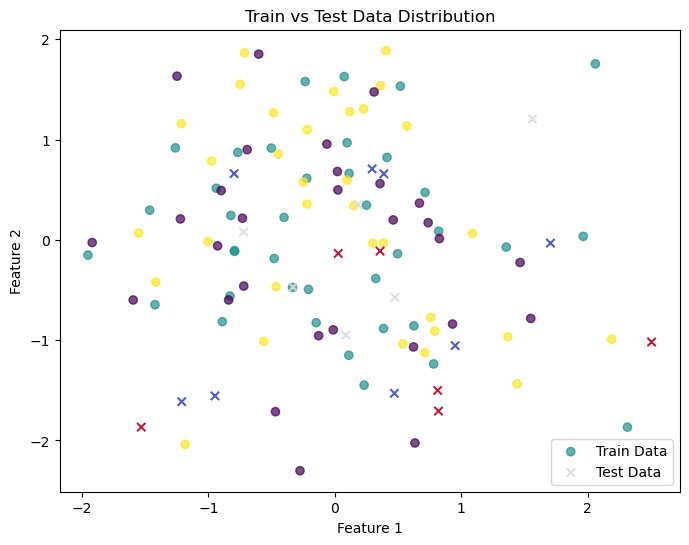

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', label='Train Data', alpha=0.7)
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='coolwarm', marker='x', label='Test Data', alpha=0.9)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Train vs Test Data Distribution")
plt.show()